<a href="https://colab.research.google.com/github/appletreeleaf/ML_Projects/blob/main/TimeSeriesModel_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 2. Load Data

[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>


<Axes: xlabel='Date'>

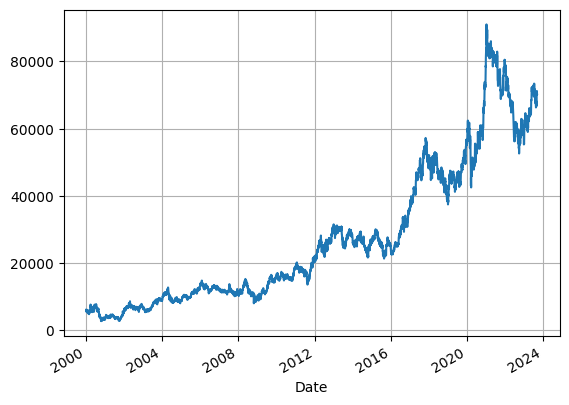

In [7]:
start = (2000, 1, 1)  # 2020년 01년 01월
start = datetime.datetime(*start)
end = datetime.date.today()  # 현재

# yahoo 에서 삼성 전자 불러오기
# df = pdr.DataReader('005930.KS', 'yahoo', start, end) !! error !! -> pdr override해서 해결
import yfinance as yfin

yfin.pdr_override()

df = pdr.get_data_yahoo('005930.KS', start=start, end=end) # return dataframe
print(df)
df.Close.plot(grid=True)

## 3. Preprocessing

In [22]:
"""
open 시가
high 고가
low 저가
close 종가
volume 거래량
Adj Close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

확실한건 거래량(Volume)은 데이터에서 제하는 것이 중요하고,
Y 데이터를 Adj Close로 정합니다. (종가로 해도 된다고 생각합니다.)

"""
X = df.drop(columns='Volume')
print(df)
y = np.array(X.iloc[:, -1]).reshape(-1, 1)

print("X = \n", X)
print("y = \n",y)

               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2000-01-04   6000.0   6110.0   5660.0   6110.0   4514.581055  74195000
2000-01-05   5800.0   6060.0   5520.0   5580.0   4122.972656  74680000
2000-01-06   5750.0   5780.0   5580.0   5620.0   4152.526855  54390000
2000-01-07   5560.0   5670.0   5360.0   5540.0   4093.417969  40305000
2000-01-10   5600.0   5770.0   5580.0   5770.0   4263.359863  46880000
...             ...      ...      ...      ...           ...       ...
2023-09-04  72900.0  72900.0  70700.0  71200.0  71200.000000  26286495
2023-09-05  70900.0  71500.0  70200.0  70700.0  70700.000000  12330239
2023-09-06  70700.0  70800.0  69700.0  70000.0  70000.000000  11414620
2023-09-07  70000.0  70600.0  69600.0  70400.0  70400.000000  13741241
2023-09-08  70200.0  70300.0  69600.0  70300.0  70300.000000  10688118

[5944 rows x 6 columns]
X = 
                Open     High      Low    Close

In [23]:
"""
학습이 잘되기 위해 데이터 정규화
StandardScaler	각 특징의 평균을 0, 분산을 1이 되도록 변경
MinMaxScaler	최대/최소값이 각각 1, 0이 되도록 변경
"""

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

# Train Data
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]

# Test Data
"""
( 굳이 없어도 된다. 하지만 얼마나 예측데이터와 실제 데이터의 정확도를 확인하기 위해
from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. )
"""
y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (4500, 5) (4500, 1)
Testing Shape (1444, 5) (1444, 1)


In [25]:
"""
torch Variable에는 3개의 형태가 있다.
data, grad, grad_fn 한 번 구글에 찾아서 공부해보길 바랍니다.
"""
# ndarray to tensor
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1444, 1, 5]) torch.Size([1444, 1])


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Tesla T4
Tesla T4


In [28]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    # hyper parameter
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state size
    self.seq_length = seq_length #sequence length
    # define layer
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer
    # activation function
    self.relu = nn.ReLU()

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output

    return out

In [30]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [31]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer


In [32]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve(update) from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01458
Epoch: 100, loss: 0.01224
Epoch: 200, loss: 0.01129
Epoch: 300, loss: 0.01097
Epoch: 400, loss: 0.01084
Epoch: 500, loss: 0.01076
Epoch: 600, loss: 0.01067
Epoch: 700, loss: 0.01059
Epoch: 800, loss: 0.01050
Epoch: 900, loss: 0.01041
Epoch: 1000, loss: 0.01032
Epoch: 1100, loss: 0.01023
Epoch: 1200, loss: 0.01014
Epoch: 1300, loss: 0.01003
Epoch: 1400, loss: 0.00993
Epoch: 1500, loss: 0.00982
Epoch: 1600, loss: 0.00970
Epoch: 1700, loss: 0.00958
Epoch: 1800, loss: 0.00945
Epoch: 1900, loss: 0.00931
Epoch: 2000, loss: 0.00917
Epoch: 2100, loss: 0.00902
Epoch: 2200, loss: 0.00887
Epoch: 2300, loss: 0.00871
Epoch: 2400, loss: 0.00854
Epoch: 2500, loss: 0.00837
Epoch: 2600, loss: 0.00820
Epoch: 2700, loss: 0.00802
Epoch: 2800, loss: 0.00784
Epoch: 2900, loss: 0.00766
Epoch: 3000, loss: 0.00747
Epoch: 3100, loss: 0.00729
Epoch: 3200, loss: 0.00710
Epoch: 3300, loss: 0.00691
Epoch: 3400, loss: 0.00672
Epoch: 3500, loss: 0.00653
Epoch: 3600, loss: 0.00634
Epoch: 3700, 

## 7. Predict

In [45]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(np.array(df['Adj Close']).reshape(-1, 1))

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))


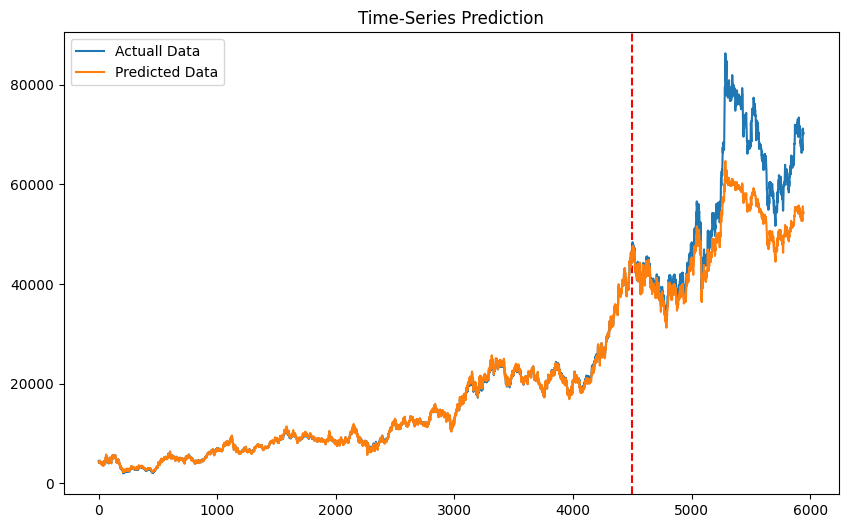

In [46]:
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()